# Project 3: Crystal Lattice

### Defining a class called "Atom" 

In [8]:
from vpython import *
import numpy as np
import random
import matplotlib.pyplot as plt

global t, dt, times, potential_energies, kinetic_energies, total_energies

class Atom:
    def __init__(self, position, velocity):
        self.position = vec(*position)
        self.velocity = vec(*velocity)
        self.origin = vec(*position)
        self.mass = 1
        self.obj = sphere(pos=self.position, radius=0.3, color=vector(0,0.58,0.69))
        self.neighbors = []
        self.distance = {}
                
    def total_force(self, k):
        net_force = vector(0, 0, 0)
        for neighbor in self.neighbors:
            f1 = -k*(self.position - self.origin)
            f2 = -k*(neighbor.position - neighbor.origin)
            f = f1 + f2
            net_force += f
        return net_force
    
    def total_force_damping(self, k, b):
        net_force = vector(0, 0, 0)
        for neighbor in self.neighbors:
            f1 = -k*(self.position - self.origin)
            f2 = -k*(neighbor.position - neighbor.origin)
            f_damping = -b * self.velocity
            f = f1 + f2 + f_damping
            net_force += f
        return net_force

### Defining helper functions and intergration methods

In [ ]:
def calculate_energy(matrix, kinetic_energy, potential_energy, time, t):
    KE = 0
    PE = 0
    for x in range(-1, 2):
        for y in range(-1, 2):
            for z in range(-1, 2):
                atom = matrix[x][y][z]
                KE += 0.5 * atom.mass * dot(atom.velocity, atom.velocity)
                PE += 0.5  * k *mag(atom.position - atom.origin)**2
    
    # Append energy values to lists
    potential_energy.append(PE)
    kinetic_energy.append(KE)
    time.append(t)

def plot_energy():
    # Plot energy values
    plt.plot(times, potential_energies, label='Potential Energy')
    plt.plot(times, kinetic_energies, label='Kinetic Energy')
    plt.plot(times, [potential_energies[i] + kinetic_energies[i] for i in range(len(times))], label='Total Energy')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.show()
    
def update_pos_verlet(atom, dt, k):
    F1 = atom.total_force(k)    # Update position using Verlet algorithm
    atom.position += atom.velocity * dt + 0.5 * (F1 / atom.mass) * dt ** 2     # Compute force at new position
    F2 = atom.total_force(k)    # Update velocity using Verlet algorithm
    atom.velocity += 0.5 * ((F1 + F2) / atom.mass) * dt            # Update the sphere object position
    atom.obj.pos = atom.position

def update_pos_backwardEuler(atom, dt, k):
    # Update position first then find next velocity
    atom.position += atom.velocity*dt
    atom.obj.pos = atom.position
    F = atom.total_force(k)
    acceleration = F/atom.mass
    atom.velocity += acceleration*dt
    
def update_pos_forwardEuler(atom, dt, k):
    # Update position with next velocity
    F = atom.total_force(k)
    acceleration = F/atom.mass
    atom.velocity += acceleration*dt
    atom.position += atom.velocity*dt
    atom.obj.pos = atom.position
    
def update_pos_damping(atom, dt, k, b):
    F1 = atom.total_force_damping(k, b)    # Update position using Verlet algorithm
    atom.position += atom.velocity * dt + 0.5 * (F1 / atom.mass) * dt ** 2     # Compute force at new position
    F2 = atom.total_force_damping(k, b)    # Update velocity using Verlet algorithm
    atom.velocity += 0.5 * ((F1 + F2) / atom.mass) * dt            # Update the sphere object position
    atom.obj.pos = atom.position

### Defining function to Initilize and Reset the system

In [ ]:
def reset_system():
    global t, dt, times, potential_energies, kinetic_energies, total_energies
    t = 0
    dt = 0.01
    times = [0]
    potential_energies = [0]
    kinetic_energies = [0]
    total_energies = [0]

def init_system(t, times, potential_energies, kinetic_energies, total_energies):
    scene = canvas()

    # Initialize the matrix of atoms
    t = 0
    times = [0]
    potential_energies = [0]
    kinetic_energies = [0]
    total_energies = [0]
    k = 1  # Spring constant
    m = 1
    dt = 0.01
    atoms_matrix = np.empty((3, 3, 3), dtype=Atom)
    for i in range(-1, 2):
        for j in range(-1, 2):
            for k in range(-1, 2):
                position = [i, j, k]
                velocity = [random.uniform(-0.3, 0.3), random.uniform(-0.3, 0.3), random.uniform(-0.3, 0.3)]
                atoms_matrix[i][j][k] = Atom(position, velocity)

    for x in range(-1, 2):
        for y in range(-1, 2):
            for z in range(-1, 2):
                atom = atoms_matrix[x][y][z]
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        for dz in [-1, 0, 1]:
                            if dx == dy == dz == 0:
                                continue  # Skip the central atom
                            nx = x + dx
                            ny = y + dy
                            nz = z + dz
                            if -1 <= nx < 2 and -1 <= ny < 2 and -1 <= nz < 2:
                                neighbor = atoms_matrix[nx][ny][nz]
                                atom.neighbors.append(neighbor)
                                distance = norm(neighbor.position - atom.position)
                                atom.distance[neighbor] = distance
    return atoms_matrix
                        

# Molecular Crystal Structure (Undamped)

## Simulation 1: Velocity Verlet Integration

In [ ]:
reset_system()
atoms_matrix = init_system(t, times, potential_energies, kinetic_energies, total_energies)
dt = 0.01

while t < 10:
    rate(100)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                atom = atoms_matrix[i][j][k]
                update_pos_verlet(atom, dt, 0.5)
    calculate_energy(atoms_matrix, kinetic_energies, potential_energies, times, t) 
    t += dt
plot_energy()

## Simulation 2: Backward Euler Integration

In [ ]:
reset_system()
atoms_matrix = init_system(t, times, potential_energies, kinetic_energies, total_energies)
dt = 0.05

while t < 10:
    rate(100)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                atom = atoms_matrix[i][j][k]
                update_pos_backwardEuler(atom, dt, 0.5)
    calculate_energy(atoms_matrix, kinetic_energies, potential_energies, times, t) 
    t += dt
plot_energy()

## Simulation 3: Forward Euler Integration

In [ ]:
reset_system()
atoms_matrix = init_system(t, times, potential_energies, kinetic_energies, total_energies)

dt = 0.03

while t < 10:
    rate(100)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                atom = atoms_matrix[i][j][k]
                update_pos_forwardEuler(atom, dt, 0.5)
    calculate_energy(atoms_matrix, kinetic_energies, potential_energies, times, t) 
    t += dt
plot_energy()

# Molecular Crystal Structure (Spring Damping)

## Simulation 4: Verlet Integeration with Spring Damping

<IPython.core.display.Javascript object>

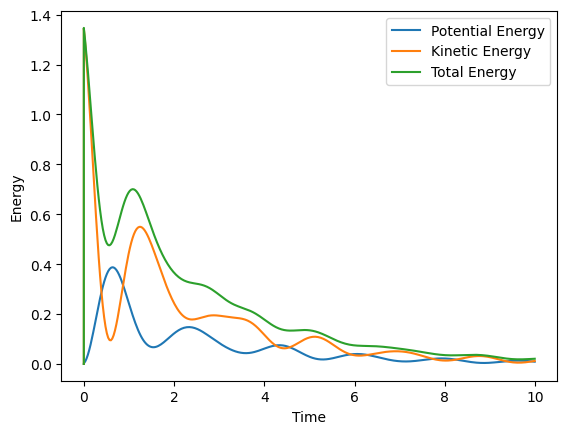

In [16]:
reset_system()
atoms_matrix = init_system(t, times, potential_energies, kinetic_energies, total_energies)

dt = 0.03
b = 0.04

while t < 10:
    rate(100)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                atom = atoms_matrix[i][j][k]
                update_pos_damping(atom, dt, 0.5, b)
    calculate_energy(atoms_matrix, kinetic_energies, potential_energies, times, t) 
    t += dt
plot_energy()